# Roller Coaster: Second Dataset

In [1]:
# All the necessary libraries for this project
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import sklearn
import itertools
import statistics
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn import tree
from xgboost import XGBClassifier

In [2]:
# Helper function drawing a nicely formatted heatmap
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_xticklabels(col_labels)
    
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

In [3]:
# Helper function that allows you to draw nicely formatted confusion matrices
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=90)
    plt.yticks(np.arange(num_classes), classes)
    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

## Data Cleaning and EDA

In [4]:
df = pd.read_csv('coaster_db.csv')
df.head()

,coaster_name,Length,Speed,Location,Status,Opening date,Type,Manufacturer,Height restriction,Model,...,speed1,speed2,speed1_value,speed1_unit,speed_mph,height_value,height_unit,height_ft,Inversions_clean,Gforce_clean
0,Switchback Railway,600 ft (180 m),6 mph (9.7 km/h),Coney Island,Removed,"June 16, 1884",Wood,LaMarcus Adna Thompson,NaN,Lift Packed,...,6 mph,9.7 km/h,6.0,mph,6.0,50.0,ft,NaN,0,2.9
1,Flip Flap Railway,NaN,NaN,Sea Lion Park,Removed,1895,Wood,Lina Beecher,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12.0
2,Switchback Railway (Euclid Beach Park),NaN,NaN,"Cleveland, Ohio, United States",Closed,NaN,Other,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN
3,Loop the Loop (Coney Island),NaN,NaN,Other,Removed,1901,Steel,Edwin Prescott,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,Loop the Loop (Young's Pier),NaN,NaN,Other,Removed,1901,Steel,Edwin Prescott,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [5]:
# Take note of the variables, these are the quantitative variables
df.describe()

,Inversions,year_introduced,latitude,longitude,speed1_value,speed_mph,height_value,height_ft,Inversions_clean,Gforce_clean
count,932.000000,1087.000000,812.000000,812.000000,937.000000,937.000000,965.000000,171.000000,1087.000000,362.000000
mean,1.547210,1994.986201,38.373484,-41.595373,53.850374,48.617289,89.575171,101.996491,1.326587,3.824006
std,2.114073,23.475248,15.516596,72.285227,23.385518,16.678031,136.246444,67.329092,2.030854,0.989998
min,0.000000,1884.000000,-48.261700,-123.035700,5.000000,5.000000,4.000000,13.100000,0.000000,0.800000
25%,0.000000,1989.000000,35.031050,-84.552200,40.000000,37.300000,44.000000,51.800000,0.000000,3.400000
50%,0.000000,2000.000000,40.289800,-76.653600,50.000000,49.700000,79.000000,91.200000,0.000000,4.000000
75%,3.000000,2010.000000,44.799600,2.778100,63.000000,58.000000,113.000000,131.200000,2.000000,4.500000
max,14.000000,2022.000000,63.230900,153.426500,240.000000,149.100000,3937.000000,377.300000,14.000000,12.000000


In [6]:
# Take note of the 'object' dtypes. These will have to be dropped, converted to numeric, or encoded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   coaster_name                   1087 non-null   object 
 1   Length                         953 non-null    object 
 2   Speed                          937 non-null    object 
 3   Location                       1087 non-null   object 
 4   Status                         874 non-null    object 
 5   Opening date                   837 non-null    object 
 6   Type                           1087 non-null   object 
 7   Manufacturer                   1028 non-null   object 
 8   Height restriction             831 non-null    object 
 9   Model                          744 non-null    object 
 10  Height                         965 non-null    object 
 11  Inversions                     932 non-null    float64
 12  Lift/launch system             795 non-null    o

**Some of these columns we will want to drop and some we will want to modify/clean up so as to use them properly.** 

    -For example, with speed, we can just use 'speed_mph' and drop the other types of speed and units. They're not telling us different useful info but the same speed in different units. For these we will select what's already in the cleanest format which is 'speed_mph' and we will treat other columns with similar issues the same
    
    -Some columns like 'Flash Pass available' simply don't seem useful for our purposes and we can just get rid of them

    -For columns like 'Length' we are given only one column with both the number and unit. We just want the number and not the unit, so we can clean up the formatting to just give us the numeric value we want, as we can do with similarly formatted columns

In [7]:
columns_to_drop = ['Speed', 'Theme', 'Type', 'Height', 'Inversions', 'Opening date', 'Park section', 'Soft opening date', 'Fast Lane available', 'Replaced',
                    'Fastrack available', 'Soft opening date.1','Closing date', 'Opened', 'Replaced by', 'Website',
                    'Flash Pass available', 'Flash Pass Available', 'Must transfer from wheelchair', 'Single rider line available', 
                     'Flash Pass available', 'speed1', 'speed2', 'speed1_value', 'speed1_unit', 'height_value', 
                    'height_unit', 'Name', 'G-force']
df.drop(columns=columns_to_drop, inplace=True)
df.head()

,coaster_name,Length,Location,Status,Manufacturer,Height restriction,Model,Lift/launch system,Cost,Trains,...,Restraints,year_introduced,latitude,longitude,Type_Main,opening_date_clean,speed_mph,height_ft,Inversions_clean,Gforce_clean
0,Switchback Railway,600 ft (180 m),Coney Island,Removed,LaMarcus Adna Thompson,NaN,Lift Packed,gravity,NaN,NaN,...,NaN,1884,40.5740,-73.9780,Wood,1884-06-16,6.0,NaN,0,2.9
1,Flip Flap Railway,NaN,Sea Lion Park,Removed,Lina Beecher,NaN,NaN,NaN,NaN,a single car. Riders are arranged 1 across in ...,...,NaN,1895,40.5780,-73.9790,Wood,1895-01-01,NaN,NaN,1,12.0
2,Switchback Railway (Euclid Beach Park),NaN,"Cleveland, Ohio, United States",Closed,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1896,41.5800,-81.5700,Other,NaN,NaN,NaN,0,NaN
3,Loop the Loop (Coney Island),NaN,Other,Removed,Edwin Prescott,NaN,NaN,NaN,NaN,a single car. Riders are arranged 2 across in ...,...,NaN,1901,40.5745,-73.9780,Steel,1901-01-01,NaN,NaN,1,NaN
4,Loop the Loop (Young's Pier),NaN,Other,Removed,Edwin Prescott,NaN,NaN,NaN,NaN,NaN,...,NaN,1901,39.3538,-74.4342,Steel,1901-01-01,NaN,NaN,1,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   coaster_name        1087 non-null   object 
 1   Length              953 non-null    object 
 2   Location            1087 non-null   object 
 3   Status              874 non-null    object 
 4   Manufacturer        1028 non-null   object 
 5   Height restriction  831 non-null    object 
 6   Model               744 non-null    object 
 7   Lift/launch system  795 non-null    object 
 8   Cost                382 non-null    object 
 9   Trains              718 non-null    object 
 10  Duration            765 non-null    object 
 11  Capacity            575 non-null    object 
 12  Designer            578 non-null    object 
 13  Max vertical angle  357 non-null    object 
 14  Drop                494 non-null    object 
 15  Track layout        335 non-null    object 
 16  Restra

In [9]:
df['Height restriction'].unique()[:50]

array([nan, '46\xa0in (117\xa0cm)', '100\xa0cm (3\xa0ft 3\xa0in)',
       '48\xa0in (122\xa0cm)', '42\xa0in (107\xa0cm)',
       '50\xa0in (127\xa0cm)', '52\xa0in (132\xa0cm)',
       '54\xa0in (137\xa0cm)', '140\xa0cm (4\xa0ft 7\xa0in)',
       '36\xa0in (91\xa0cm)', '40\xa0in (102\xa0cm)',
       '44\xa0in (112\xa0cm)', '42 or 48\xa0in (107 or 122\xa0cm)',
       '20\xa0in (51\xa0cm)', '47.3\xa0in (120\xa0cm)',
       '122\xa0cm (4\xa0ft 0\xa0in)', '102\xa0cm (3\xa0ft 4\xa0in)',
       '120\xa0cm (3\xa0ft 11\xa0in)', '130\xa0cm (4\xa0ft 3\xa0in)',
       '90\xa0cm (2\xa0ft 11\xa0in)',
       '120–205\xa0cm (3\xa0ft 11\xa0in–6\xa0ft 9\xa0in)',
       '59–77\xa0in (150–196\xa0cm)', '34\xa0in (86\xa0cm)',
       'Must be able to straddle seat with feet on floor.',
       '47.24\xa0in (120\xa0cm)', '54–76\xa0in (137–193\xa0cm)',
       '43.3\xa0in (110\xa0cm)', '51\xa0in (130\xa0cm)',
       '54–78[1]\xa0in (137–198\xa0cm)', '35\xa0in (89\xa0cm)',
       '110\xa0cm (3\xa0ft 7\xa0in)',
  

In [10]:
df['Cost'].unique()[:50]

array([nan, '$50,000', '$75,000', '$140,000', '$50,000 USD',
       '£25,000 (1922)', 'USD$50,000', '$125,000', 'less than $20,000',
       '$176,000 CDN', '$250,000', '$175,000', '$200,000',
       '48 million FIM (1951);[1]1.62 million EUR (in 2021 euros, inflation-adjusted)[2]',
       '$1,000,000', '$1,200,000 USD', '$1,200,000', '$1,750,000 USD',
       '$500,000', '$400,000',
       'US$2 million($9.1\xa0million in 2020 dollars[1])', '$2,000,000',
       '$3,000,000 (1976)', '$1,600,000', '$1.35 million', '$3 million',
       '£813,000', '$2.3 million', '$3,400,000', '$5,000,000[1]',
       '$2.8 million', '$3.2 million', '£1,000,000', '$2,100,000',
       'US$2.5 million – US$3 million', '$10 million', '$3,800,000',
       '$1.2M est.', '€ 9,4 million', '$2.7M est.', '1.2M',
       'A$3.3 million', '$6.5 million', '2.5 Million', 'US$10 million',
       'CA$9 million[1]', 'USD $150,000', '$6,000,000',
       '£1 million Rebuild', '3,000,000 USD'], dtype=object)

In [11]:
df['Acceleration'].unique()[:50]

array([nan, '0 to 55 mph (0 to 89 km/h) in 3 seconds',
       '0 to 87 km/h (0 to 54 mph) in 4 seconds', '4',
       '0 to 54 mph (0 to 87 km/h) in 4 seconds', '5 mrsn',
       '+2.75g (25 m/s)', '0 to 104 mph in 7 seconds',
       '0 to 160.9 km/h (0 to 100 mph) in 7 seconds',
       '0 to 65\xa0mph (105\xa0km/h) in 4 seconds',
       '0 to 70 mph (0 to 113 km/h) in 3.8 seconds',
       '0 to 40 mph (0 to 64 km/h) in 2 seconds', '0 - 60 in 3 seconds',
       '0 to 60 mph (0 to 97 km/h) in 3.5 seconds',
       '0–53 mph in 2.8 seconds',
       '0 to 57 mph (0 to 92 km/h) in 2.8 seconds', '0 to 45 to 70mph',
       '0 − 55.9 mph in 2.8 seconds',
       '0 to 55 mph (0 to 89 km/h) in 4.5 seconds',
       '0 to 180 km/h (0 to 112 mph) in 1.6 seconds',
       '0-80 in 1.8 seconds', '0-60 mph in 4.0 seconds',
       '0 − 82\xa0mph (132\xa0km/h) in 2.3 seconds',
       '0 to 120 mph (0 to 193 km/h) in 4 seconds',
       '"0 to 46.6 mph (0 to 75 km/h) in 3 seconds".',
       '0 to 72 mph (0 t

In [12]:
df['Max vertical angle'].unique()[:50]

array(['30°', nan, '25°', '64°', '45°', '52°', '46°',
       '40 degrees at bottom of first drop°', '59°', '58.1°', '35°',
       '39°', '50°', '47°', '3°', '1°', '54°', '55°', '53°', '80°', '70°',
       '62°', '43°', '42°', '36°', '33°', '60°', '78°', '85°', '27°',
       '89°', '97°', '65°', '79°', '75°', '48°', '81°', '29°', '40°',
       '56°', '13°', '61°', '90°', '51°', '66°', '87.5°', '53.3°', '91°',
       '76°', '68°'], dtype=object)

In [13]:
df['Duration'].unique()[:50]

array(['1:00', nan, '1 minute 30 seconds', '1:32', '1:58', '1:52', '1:36',
       '2:28', '1:41', '1:18', '1:45', '1:17', '1:10', '2:30', '1:15',
       'between 1 minute 20 seconds and 1 minute 30 seconds', '1:30',
       '1:40', '3:10', '1:44', '3 min (approx)', '2:20[1]', '2:20',
       '2:00', '1:50', '2:10', '0:50', '1:24', '2:15[4]', '1min 30sec',
       '2:07', '3:20', '2:51', '2:50', '1:29', '6:33', '0:30', '3:00',
       '3:15', '2 min. 30 sec.', '2:17', '2:15', '0:22', '2:23', '0:27',
       '1:08', '79 seconds', '1:06', '3:00 min', '2:00[1]'], dtype=object)

In [14]:
df['Capacity'].unique()[:50]

array(['1600 riders per hour', nan, '1400 riders per hour',
       '85 riders per hour', '1440 riders per hour',
       '600 riders per hour', '1,100 riders per hour',
       '950 riders per hour', '1,320 riders per hour',
       '640 riders per hour', '1,400 riders per hour',
       '2010 riders per hour', '2200 riders per hour',
       '2400 riders per hour', '500 riders per hour',
       '1750 riders per hour', '360 riders per hour',
       '1800 riders per hour', '1000 riders per hour',
       '2640 riders per hour', '1200 riders per hour',
       '2,000 riders per hour', '900 riders per hour',
       '1125 riders per hour', '1250 riders per hour',
       '480 riders per hour', '1,800 riders per hour',
       '1300 riders per hour', '1,150 riders per hour',
       '1,200 riders per hour', '450 riders per hour',
       '810 riders per hour', '525 riders per hour',
       '1175 riders per hour',
       '2,057 (11 rockets) 1,741 (10 rockets) 1,440 (9 rockets) riders per hour',
       

In [15]:
df['Drop'].unique()[:50]

array(['43\xa0ft (13\xa0m)', nan, '9\xa0ft (2.7\xa0m)',
       '50\xa0ft (15\xa0m)', '70\xa0ft (21\xa0m)', '88\xa0ft (27\xa0m)',
       '40\xa0ft (12\xa0m)', '75\xa0ft (23\xa0m)',
       '59.58\xa0ft (18.16\xa0m)', '65\xa0ft (20\xa0m)',
       '90\xa0ft (27\xa0m)', '60\xa0ft (18\xa0m)', '78\xa0ft (24\xa0m)',
       '23\xa0m (75\xa0ft)', '19.4\xa0m (64\xa0ft)', '51\xa0ft (16\xa0m)',
       '54\xa0ft (16\xa0m)', '25\xa0ft (7.6\xa0m)', '80\xa0ft (24\xa0m)',
       '24\xa0ft (7.3\xa0m)', '12\xa0ft (3.7\xa0m)', '67\xa0ft (20\xa0m)',
       '72\xa0ft (22\xa0m)', '35\xa0ft (11\xa0m)', '41\xa0ft (12\xa0m)',
       '20\xa0ft (6.1\xa0m)', '82.17\xa0ft (25.0\xa0m)',
       '30\xa0ft (9.1\xa0m)', '34\xa0ft (10\xa0m)', '89\xa0ft (27\xa0m)',
       '2.44\xa0m (8.0\xa0ft)', '62\xa0ft (19\xa0m)',
       '81\xa0ft (24.7\xa0m)', '26\xa0ft (7.9\xa0m)',
       '2\xa0ft (0.61\xa0m)', '56\xa0ft (17\xa0m)', '3\xa0ft (0.91\xa0m)',
       '83\xa0ft (25\xa0m)', '92\xa0ft (28\xa0m)', '88\xa0ft (26.8\xa0m)',
    

Lot's of crazily formatted columns that should ideally just be numbers. Let's start cleaning

In [16]:
# Clean length
df['Length_ft'] = df['Length'].str.extract(r'([\d,\.]+)\s*ft')
df['Length_ft'] = df['Length_ft'].str.replace(',', '').astype(float)

# Clean height restriction, need function
def extract_inches(value):
    if pd.isna(value):
        return np.nan

    s = str(value)
    s = s.replace('\xa0', ' ')  # remove non-breaking spaces
    s = s.strip()

    # Handle non-numeric or text-based cases
    if not re.search(r'\d', s):
        return np.nan

    # Handle "or" cases like "42 or 48 in (107 or 122 cm)"
    if ' or ' in s:
        return np.nan

    # Extract all ranges like "120–205 cm" or "59–77 in"
    range_match = re.findall(r'(\d+(?:\.\d+)?)\s*[–-]\s*(\d+(?:\.\d+)?)', s)
    if range_match:
        # Take the lower bound only
        low = float(range_match[0][0])
        # Detect whether the unit is in cm or inches
        if 'cm' in s:
            return low / 2.54  # convert cm to inches
        else:
            return low  # already in inches

    # Extract single inch value if present
    inch_match = re.search(r'(\d+(?:\.\d+)?)\s*in', s)
    if inch_match:
        return float(inch_match.group(1))

    # If only cm is present
    cm_match = re.search(r'(\d+(?:\.\d+)?)\s*cm', s)
    if cm_match:
        return float(cm_match.group(1)) / 2.54  # convert cm → inches

    # If no recognized numeric pattern, return NaN
    return np.nan

df['Height_restriction_in'] = df['Height restriction'].apply(extract_inches)
df.drop(columns=['Length', 'Height restriction'], inplace=True)
df.head()

,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Cost,Trains,Duration,Capacity,...,latitude,longitude,Type_Main,opening_date_clean,speed_mph,height_ft,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,NaN,NaN,1:00,1600 riders per hour,...,40.5740,-73.9780,Wood,1884-06-16,6.0,NaN,0,2.9,600.0,NaN
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,NaN,NaN,NaN,a single car. Riders are arranged 1 across in ...,NaN,NaN,...,40.5780,-73.9790,Wood,1895-01-01,NaN,NaN,1,12.0,NaN,NaN
2,Switchback Railway (Euclid Beach Park),"Cleveland, Ohio, United States",Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.5800,-81.5700,Other,NaN,NaN,NaN,0,NaN,NaN,NaN
3,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,NaN,NaN,NaN,a single car. Riders are arranged 2 across in ...,NaN,NaN,...,40.5745,-73.9780,Steel,1901-01-01,NaN,NaN,1,NaN,NaN,NaN
4,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,NaN,NaN,NaN,NaN,NaN,NaN,...,39.3538,-74.4342,Steel,1901-01-01,NaN,NaN,1,NaN,NaN,NaN


In [17]:
# Clean cost
def clean_cost(value):
    if pd.isna(value):
        return np.nan

    s = str(value).strip().lower()

    # Normalize commas to dots (for decimals)
    s = s.replace(',', '.')

    # Remove annotations and misc text
    s = re.sub(r'\[.*?\]|\(.*?\)|;|–|—', ' ', s)
    s = re.sub(r'est\.?|rebuild|less than|approximately|about|around', '', s)

    # Handle ranges like "2.5 million – 3 million" → take average
    range_match = re.findall(r'([\d\.]+)\s*(?:m|million)?', s)
    if len(range_match) >= 2:
        valid_nums = []
        for x in range_match[:2]:
            # only keep if there's at least one digit
            if re.search(r'\d', x):
                # handle formats like 1.000.000
                if x.count('.') > 1:
                    x = x.replace('.', '')
                try:
                    valid_nums.append(float(x))
                except ValueError:
                    continue
        if valid_nums:
            avg_val = np.mean(valid_nums)
            s = f'{avg_val} million'

    # Detect currency
    if '£' in s or 'gbp' in s:
        currency = 'GBP'
    elif '€' in s or 'eur' in s:
        currency = 'EUR'
    elif 'a$' in s or 'aud' in s:
        currency = 'AUD'
    elif 'ca$' in s or 'cdn' in s or 'cad' in s:
        currency = 'CAD'
    elif 'fim' in s:
        currency = 'FIM'
    else:
        currency = 'USD'

    # Remove everything except digits, dots, and 'm'
    s = re.sub(r'[^0-9\.m]', '', s)

    # Detect "million" or "M" multiplier
    multiplier = 1
    if 'million' in value.lower() or re.search(r'\d+\.?\d*m', value.lower()):
        multiplier = 1_000_000

    # Handle “1.000.000” → “1000000”
    if s.count('.') > 1 and multiplier == 1:
        s = s.replace('.', '')

    # Extract numeric part
    match = re.search(r'[\d\.]+', s)
    if not match or not re.search(r'\d', match.group()):
        return np.nan

    try:
        num = float(match.group()) * multiplier
    except ValueError:
        return np.nan

    # Currency conversion (approximate rates)
    conversion_rates = {
        'USD': 1.0,
        'GBP': 1.25,
        'EUR': 1.1,
        'CAD': 0.73,
        'AUD': 0.65,
        'FIM': 0.19 / 1.1,
    }

    rate = conversion_rates.get(currency, 1.0)
    num_usd = num * rate

    return num_usd

df['Cost_USD'] = df['Cost'].apply(clean_cost)
df.drop(columns=['Cost'], inplace=True)

In [18]:
def clean_acceleration(value):
    if pd.isna(value):
        return np.nan

    s = str(value).lower().replace('\xa0', ' ')
    s = re.sub(r'[–—−]', '-', s)  # normalize dashes
    s = re.sub(r'["“”]', '', s)   # remove stray quotes

    # Case 1: Direct g-force
    g_match = re.search(r'([\d\.]+)\s*g', s)
    if g_match:
        g_val = float(g_match.group(1)) * 9.81
        return round(g_val, 2)

    # Case 2: Has time + speed
    time_match = re.search(r'(\d+(?:\.\d+)?)\s*(?:s|sec|second)', s)
    speed_match_mph = re.findall(r'(\d+(?:\.\d+)?)\s*mph', s)
    speed_match_kmh = re.findall(r'(\d+(?:\.\d+)?)\s*(?:km/?h|kph)', s)

    # Take the largest speed mentioned
    v_m_s = None
    if speed_match_mph:
        mph = max([float(x) for x in speed_match_mph])
        v_m_s = mph * 0.44704  # mph → m/s
    elif speed_match_kmh:
        kmh = max([float(x) for x in speed_match_kmh])
        v_m_s = kmh / 3.6       # km/h → m/s

    if time_match and v_m_s:
        t = float(time_match.group(1))
        if t > 0:
            return round(v_m_s / t, 2)

    # Case 3: "0-80 in 1.8 seconds" type (no unit) 
    alt_match = re.search(r'0\s*[-to]+\s*(\d+(?:\.\d+)?)\s*(?:in)?\s*(\d+(?:\.\d+)?)\s*(?:s|sec|second)', s)
    if alt_match:
        v = float(alt_match.group(1))
        t = float(alt_match.group(2))
        # assume mph if no unit
        return round((v * 0.44704) / t, 2)

    # Case 4: If only time or nonsense 
    return np.nan

df['Acceleration_clean'] = df['Acceleration'].apply(clean_acceleration)
df.drop(columns=['Acceleration'], inplace=True)

In [19]:
def clean_max_vertical_angle(value):
    if pd.isna(value):
        return np.nan
    value = str(value).lower().strip()

    # remove the degree symbol and words like "degrees" or extra notes
    value = re.sub(r'[^0-9.\-]', ' ', value)  # keep only numbers, dots, and minus
    # extract the first numeric value in the string
    match = re.search(r'\d+(\.\d+)?', value)
    if match:
        return float(match.group())
    return np.nan

df['Max_vertical_angle'] = df['Max vertical angle'].apply(clean_max_vertical_angle)
df.drop(columns=['Max vertical angle'], inplace=True)

In [20]:
def duration_to_seconds(value):
    if pd.isna(value):
        return np.nan
    value = str(value).lower().strip()

    # remove annotations like [1], [4], (approx)
    value = re.sub(r'\[.*?\]|\(.*?\)', '', value)

    # handle ranges (use upper bound)
    if "between" in value and "and" in value:
        parts = re.split(r'\band\b', value)
        value = parts[-1]  # take upper bound
    elif "-" in value and not re.search(r'\d:\d{2}', value):
        # e.g. "1:20 - 1:30" or "1 min - 2 min"
        parts = re.split(r'[-–]', value)
        value = parts[-1]

    # Handle colon format (e.g. 1:32 → 92 sec)
    colon_match = re.match(r'(\d+):(\d+)', value)
    if colon_match:
        minutes = int(colon_match.group(1))
        seconds = int(colon_match.group(2))
        return minutes * 60 + seconds

    # Handle cases like '3 min 15 sec', '1min 30sec', '3:00 min', etc.
    minutes = 0
    seconds = 0

    min_match = re.search(r'(\d+(?:\.\d+)?)\s*(?:min|minute)', value)
    sec_match = re.search(r'(\d+(?:\.\d+)?)\s*(?:sec|second)', value)
    if min_match:
        minutes = float(min_match.group(1))
    if sec_match:
        seconds = float(sec_match.group(1))
    if minutes or seconds:
        return minutes * 60 + seconds

    # Handle "3 min" or "3:00 min"
    only_min = re.match(r'(\d+(?:\.\d+)?)\s*min', value)
    if only_min:
        return float(only_min.group(1)) * 60

    # Handle "79 seconds"
    only_sec = re.match(r'(\d+(?:\.\d+)?)\s*sec', value)
    if only_sec:
        return float(only_sec.group(1))

    # Handle plain seconds or minutes like "90", "3 minutes"
    if re.match(r'^\d+(\.\d+)?$', value):
        return float(value)
    if 'minute' in value:
        num = re.findall(r'\d+(?:\.\d+)?', value)
        if num:
            return float(num[-1]) * 60

    return np.nan  # fallback

df['Duration_seconds'] = df['Duration'].apply(duration_to_seconds)
df.drop(columns=['Duration'], inplace=True)

In [21]:
def clean_capacity(value):
    if pd.isna(value):
        return np.nan

    value = str(value)

    # Remove commas and lowercase everything
    value = value.replace(',', '').lower()

    # Extract all numeric values
    numbers = re.findall(r'\d+', value)

    if not numbers:
        return np.nan

    # Convert all to integers
    numbers = [int(n) for n in numbers]

    # If it’s a range like “600–675”, take the upper bound
    if 'to' in value or '-' in value:
        return max(numbers)

    # If multiple values (like multiple ride configurations), take the maximum
    if len(numbers) > 1:
        return max(numbers)

    # Otherwise, single clean number
    return numbers[0]

df['Capacity_riders_per_hour'] = df['Capacity'].apply(clean_capacity).astype('Int64')
df.drop(columns=['Capacity'], inplace=True)

In [22]:
def clean_drop(value):
    if pd.isna(value):
        return np.nan

    value = str(value).replace('\xa0', ' ').lower()

    # Try to extract feet first
    match_ft = re.search(r'([\d.]+)\s*ft', value)
    if match_ft:
        return float(match_ft.group(1))

    # If no feet, try meters and convert to ft
    match_m = re.search(r'([\d.]+)\s*m', value)
    if match_m:
        return float(match_m.group(1)) * 3.28084  # meters → feet

    return np.nan

df['Drop_ft'] = df['Drop'].apply(clean_drop)
df.drop(columns=['Drop'], inplace=True)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              1087 non-null   object 
 1   Location                  1087 non-null   object 
 2   Status                    874 non-null    object 
 3   Manufacturer              1028 non-null   object 
 4   Model                     744 non-null    object 
 5   Lift/launch system        795 non-null    object 
 6   Trains                    718 non-null    object 
 7   Designer                  578 non-null    object 
 8   Track layout              335 non-null    object 
 9   Restraint Style           22 non-null     object 
 10  Restraints                24 non-null     object 
 11  year_introduced           1087 non-null   int64  
 12  latitude                  812 non-null    float64
 13  longitude                 812 non-null    float64
 14  Type_Mai

In [24]:
df.head()

,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,Track layout,Restraint Style,...,Inversions_clean,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,NaN,LaMarcus Adna Thompson,Gravity pulled coaster,NaN,...,0,2.9,600.0,NaN,NaN,NaN,30.0,60.0,1600,43.0
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,NaN,NaN,a single car. Riders are arranged 1 across in ...,Lina Beecher,NaN,NaN,...,1,12.0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
2,Switchback Railway (Euclid Beach Park),"Cleveland, Ohio, United States",Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
3,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,NaN,NaN,a single car. Riders are arranged 2 across in ...,Edward A. Green,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN
4,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,NaN,NaN,NaN,Edward A. Green,NaN,NaN,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,NaN


In [25]:
df.isna().sum()

coaster_name                   0
Location                       0
Status                       213
Manufacturer                  59
Model                        343
Lift/launch system           292
Trains                       369
Designer                     509
Track layout                 752
Restraint Style             1065
Restraints                  1063
year_introduced                0
latitude                     275
longitude                    275
Type_Main                      0
opening_date_clean           250
speed_mph                    150
height_ft                    916
Inversions_clean               0
Gforce_clean                 725
Length_ft                    135
Height_restriction_in        258
Cost_USD                     708
Acceleration_clean          1032
Max_vertical_angle           730
Duration_seconds             333
Capacity_riders_per_hour     512
Drop_ft                      593
dtype: int64

In [26]:
df.shape

(1087, 28)

In [27]:
# Eliminate the manufacturer NAs as they are currently only about 5%
df = df[df['Manufacturer'].notna()]
df.isna().sum()

coaster_name                   0
Location                       0
Status                       203
Manufacturer                   0
Model                        290
Lift/launch system           250
Trains                       327
Designer                     471
Track layout                 706
Restraint Style             1007
Restraints                  1004
year_introduced                0
latitude                     268
longitude                    268
Type_Main                      0
opening_date_clean           218
speed_mph                    109
height_ft                    860
Inversions_clean               0
Gforce_clean                 669
Length_ft                     97
Height_restriction_in        212
Cost_USD                     656
Acceleration_clean           973
Max_vertical_angle           677
Duration_seconds             292
Capacity_riders_per_hour     457
Drop_ft                      545
dtype: int64

In [28]:
df.shape

(1028, 28)

In [29]:
# The quantitative variable NAs are numerous so we shall impute them with the medians
# Heights, speeds, drop lengths, etc vary greatly so median will ensure outliers do not have as much affect as mean/avg
num_cols = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']

for col in num_cols:
    if col in df.columns:
        median_val = df[col].median(skipna=True)
        df[col] = df[col].fillna(median_val)

In [30]:
drop_cols = ['Restraint Style', 'Restraints', 'Track layout']
df.drop(columns=drop_cols, inplace=True)

for col in ['Status', 'Model', 'Lift/launch system', 'Trains', 'Designer', 'opening_date_clean']:
    df[col] = df[col].fillna('Unknown')
    
df.isna().sum()

coaster_name                0
Location                    0
Status                      0
Manufacturer                0
Model                       0
Lift/launch system          0
Trains                      0
Designer                    0
year_introduced             0
latitude                    0
longitude                   0
Type_Main                   0
opening_date_clean          0
speed_mph                   0
height_ft                   0
Inversions_clean            0
Gforce_clean                0
Length_ft                   0
Height_restriction_in       0
Cost_USD                    0
Acceleration_clean          0
Max_vertical_angle          0
Duration_seconds            0
Capacity_riders_per_hour    0
Drop_ft                     0
dtype: int64

In [31]:
df = df.rename(columns={'Type_Main': 'track_type'})

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1086
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   coaster_name              1028 non-null   object 
 1   Location                  1028 non-null   object 
 2   Status                    1028 non-null   object 
 3   Manufacturer              1028 non-null   object 
 4   Model                     1028 non-null   object 
 5   Lift/launch system        1028 non-null   object 
 6   Trains                    1028 non-null   object 
 7   Designer                  1028 non-null   object 
 8   year_introduced           1028 non-null   int64  
 9   latitude                  1028 non-null   float64
 10  longitude                 1028 non-null   float64
 11  track_type                1028 non-null   object 
 12  opening_date_clean        1028 non-null   object 
 13  speed_mph                 1028 non-null   float64
 14  height_f

In [33]:
df.shape

(1028, 25)

In [34]:
# write to csv to use in other files
df.to_csv('coaster_db_clean.csv')

In [35]:
# track material type will be our target for classification, so let's see its values
df['track_type'].unique()

array(['Wood', 'Steel', 'Other'], dtype=object)

In [36]:
df['track_type'].value_counts(normalize=True)

Steel    0.791829
Wood     0.172179
Other    0.035992
Name: track_type, dtype: float64

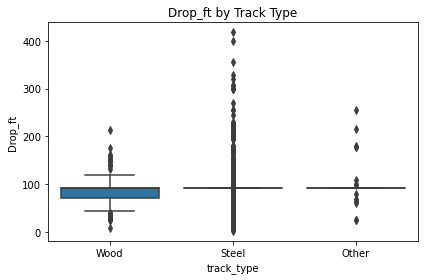

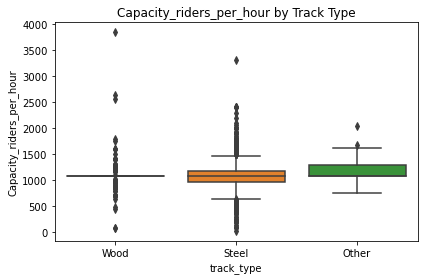

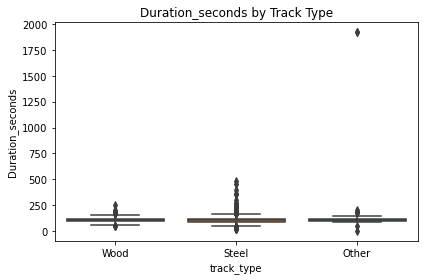

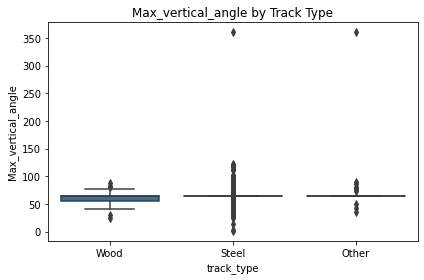

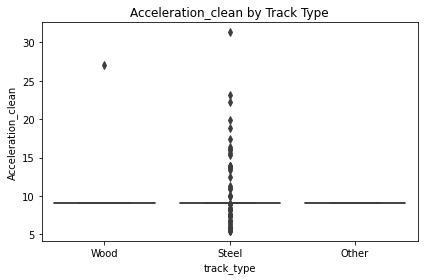

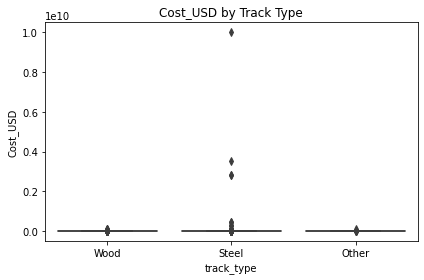

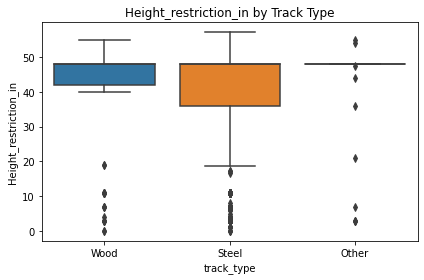

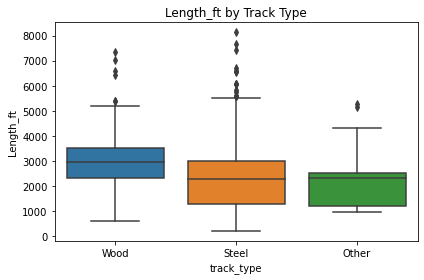

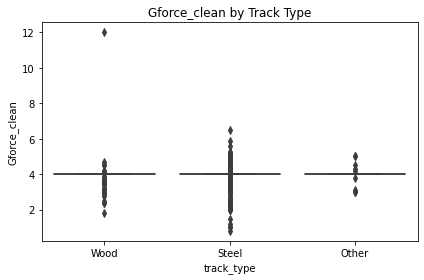

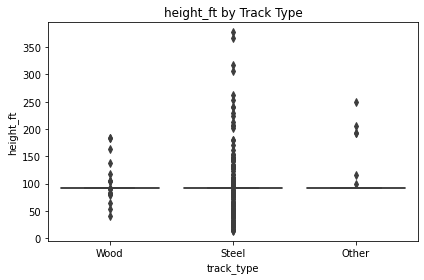

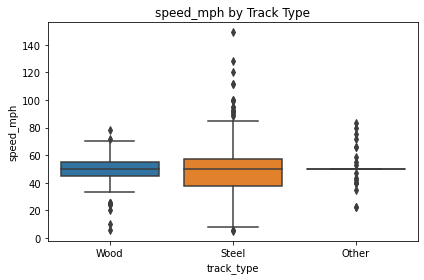

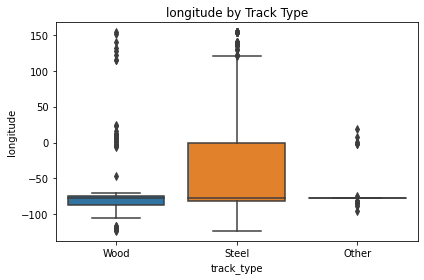

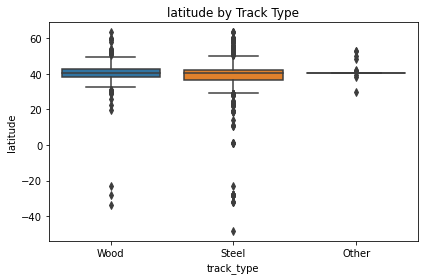

In [37]:
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='track_type', y=col, data=df)
    plt.title(f'{col} by Track Type')
    plt.tight_layout()
    plt.show()

In [38]:
# Encode track type as it is our target variable. Drop it afterward and check our data
le = LabelEncoder()
df['target'] = le.fit_transform(df['track_type'])
df = df.drop(columns = ['track_type'])
df.head()

,coaster_name,Location,Status,Manufacturer,Model,Lift/launch system,Trains,Designer,year_introduced,latitude,...,Gforce_clean,Length_ft,Height_restriction_in,Cost_USD,Acceleration_clean,Max_vertical_angle,Duration_seconds,Capacity_riders_per_hour,Drop_ft,target
0,Switchback Railway,Coney Island,Removed,LaMarcus Adna Thompson,Lift Packed,gravity,Unknown,LaMarcus Adna Thompson,1884,40.5740,...,2.9,600.0,48.0,8540000.0,9.1,30.0,60.0,1600,43.0,2
1,Flip Flap Railway,Sea Lion Park,Removed,Lina Beecher,Unknown,Unknown,a single car. Riders are arranged 1 across in ...,Lina Beecher,1895,40.5780,...,12.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0,2
3,Loop the Loop (Coney Island),Other,Removed,Edwin Prescott,Unknown,Unknown,a single car. Riders are arranged 2 across in ...,Edward A. Green,1901,40.5745,...,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0,1
4,Loop the Loop (Young's Pier),Other,Removed,Edwin Prescott,Unknown,Unknown,Unknown,Edward A. Green,1901,39.3538,...,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0,1
5,Cannon Coaster,Coney Island,Removed,George Francis Meyer,Unknown,Unknown,Unknown,Unknown,1902,40.5750,...,4.0,2300.0,48.0,8540000.0,9.1,65.0,105.0,1080,92.0,2


In [39]:
# Double check target classes
print(le.classes_)

['Other' 'Steel' 'Wood']


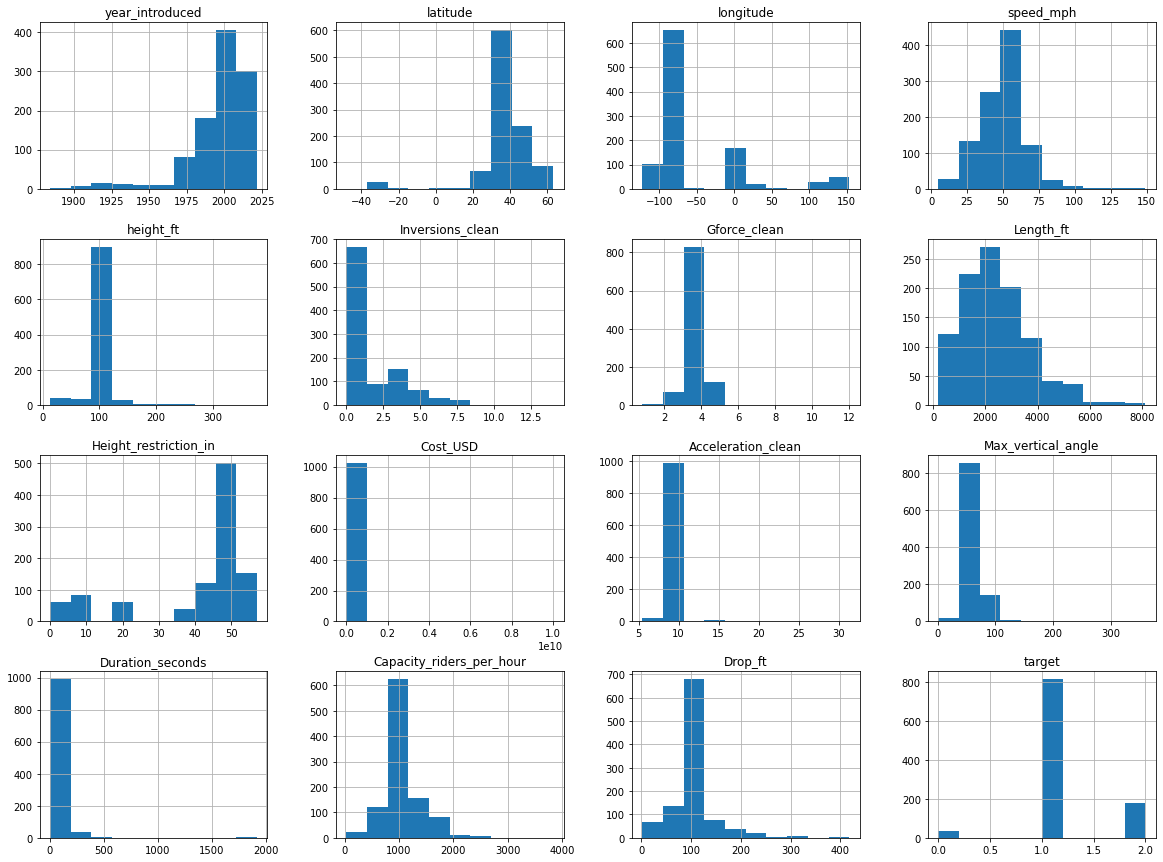

In [40]:
# Histograms of quantitative variables so we know what we're working with
df.hist(figsize = (20,15))
plt.show()

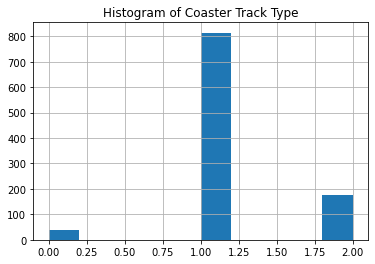

1    814
2    177
0     37
Name: target, dtype: int64

In [41]:
df['target'].hist()
plt.title('Histogram of Coaster Track Type')
plt.show()
df['target'].value_counts()

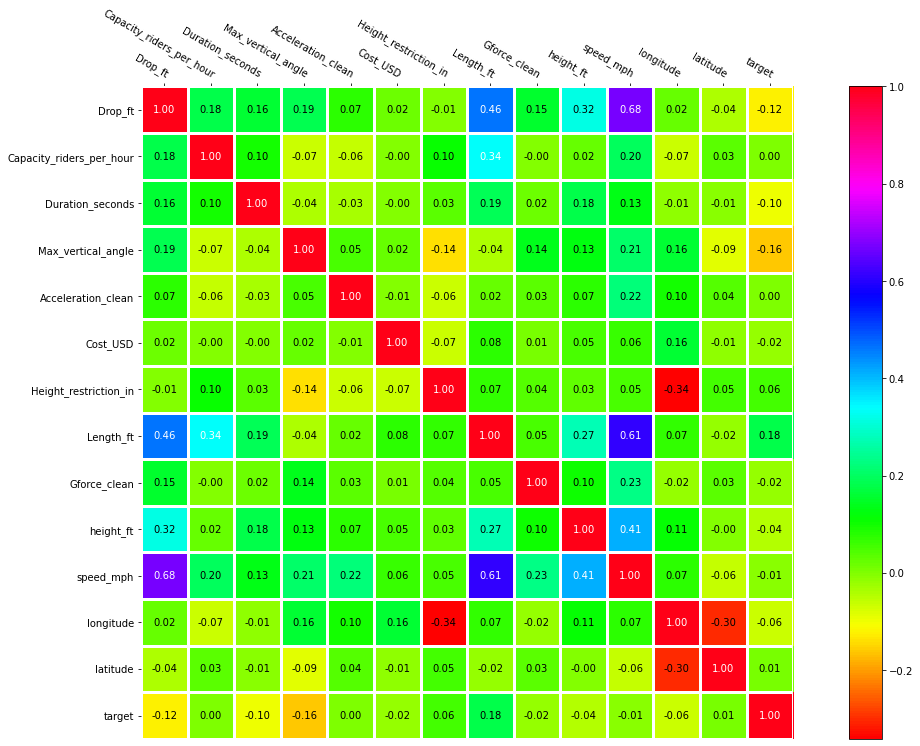

In [42]:
# Let's quickly visualize the coorrelations of our variables
correlations = df[['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude', 'target']].corr()
columns = list(df[['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude', 'target']])
heatmap(correlations.values,columns,columns,figsize = (20,12),cmap="hsv")

In [43]:
correlations['target'].sort_values(ascending=False)

target                      1.000000
Length_ft                   0.181416
Height_restriction_in       0.055822
latitude                    0.005795
Acceleration_clean          0.003457
Capacity_riders_per_hour    0.000822
speed_mph                  -0.009728
Gforce_clean               -0.016817
Cost_USD                   -0.018966
height_ft                  -0.044710
longitude                  -0.063668
Duration_seconds           -0.099969
Drop_ft                    -0.123727
Max_vertical_angle         -0.160436
Name: target, dtype: float64

In [44]:
df['target'].value_counts(normalize=True)

1    0.791829
2    0.172179
0    0.035992
Name: target, dtype: float64

In [45]:
y = df['target']
x = df.drop(['target'],axis = 1)

In [46]:
train_raw, test_raw, target, target_test = train_test_split(x, y, test_size = 0.2, stratify = y, random_state=0)

In [47]:
print("Training shape:", train_raw.shape)
print("Testing shape:", test_raw.shape)

Training shape: (822, 24)
Testing shape: (206, 24)


In [48]:
print("Training set class counts:", np.bincount(target))
print("Testing set class counts:", np.bincount(target_test))

Training set class counts: [ 30 651 141]
Testing set class counts: [  7 163  36]


## Classification Models

In [49]:
# Seperate numerical and categorical variables
num = ['Drop_ft', 'Capacity_riders_per_hour', 'Duration_seconds', 
            'Max_vertical_angle', 'Acceleration_clean', 'Cost_USD', 
            'Height_restriction_in', 'Length_ft', 'Gforce_clean', 
            'height_ft', 'speed_mph', 'longitude', 'latitude']
cat = ['coaster_name', 'Location', 'Status', 'Manufacturer', 'Model', 
       'Lift/launch system', 'Trains', 'Designer', 'opening_date_clean']

# Transform numerical with `StandardScaler()` and categorical with `OneHotEncoder()`
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num), 
    ('cat', OneHotEncoder(sparse_output = False, handle_unknown = 'ignore', categories = 'auto', drop = 'first'), cat)])

# Create Pipeline. We will try KNN first
pipeline = Pipeline([('preprocessor', preprocessor), ('knn', KNeighborsClassifier(n_neighbors=3))])

# Create training and testing sets by transforming raw data through pipeline 
train = pipeline['preprocessor'].fit_transform(train_raw)
test = pipeline['preprocessor'].transform(test_raw)

pipeline['knn'].fit(train, target)

feature_names = pipeline[:-1].get_feature_names_out()
print(feature_names)

['num__Drop_ft' 'num__Capacity_riders_per_hour' 'num__Duration_seconds'
 ... 'cat__opening_date_clean_2022-01-01'
 'cat__opening_date_clean_2022-02-01' 'cat__opening_date_clean_Unknown']


/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### KNN

In [50]:
# K-Nearest Neighbors
predicted = pipeline['knn'].predict(test)

accuracy = accuracy_score(target_test, predicted)

print("Accuracy:", accuracy)

n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]
accuracies = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train, target)
    
    predicted = knn.predict(test)
    
    accuracy = accuracy_score(target_test, predicted)
    accuracies.append(accuracy)

for n, accuracy in zip(n_values, accuracies):
    print(f"n_neighbors = {n}: Accuracy = {accuracy}")

Accuracy: 0.8543689320388349
n_neighbors = 1: Accuracy = 0.883495145631068
n_neighbors = 2: Accuracy = 0.8446601941747572
n_neighbors = 3: Accuracy = 0.8543689320388349
n_neighbors = 5: Accuracy = 0.8689320388349514
n_neighbors = 7: Accuracy = 0.8689320388349514
n_neighbors = 9: Accuracy = 0.883495145631068
n_neighbors = 10: Accuracy = 0.8640776699029126
n_neighbors = 20: Accuracy = 0.883495145631068
n_neighbors = 50: Accuracy = 0.8786407766990292


In [51]:
# K-Nearest Neighbors F1

f1 = f1_score(target_test, predicted, average = None)

print("F1:", f1)

n_values = [1, 2, 3, 5, 7, 9, 10, 20, 50]
f1s = []

for n in n_values:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(train, target)
    
    predicted = knn.predict(test)
    
    f1 = f1_score(target_test, predicted, average = None)
    f1_avg = f1_score(target_test, predicted, average = 'weighted')
    f1s.append(f1)

for n, f1 in zip(n_values, f1s):
    print(f"n_neighbors = {n}: F1's = {f1}, F1 weighted average = {f1_avg}")

F1: [0.         0.93294461 0.67741935]
n_neighbors = 1: F1's = [0.35294118 0.93457944 0.78378378], F1 weighted average = 0.8565877068916241
n_neighbors = 2: F1's = [0.3        0.90634441 0.68852459], F1 weighted average = 0.8565877068916241
n_neighbors = 3: F1's = [0.28571429 0.91515152 0.67647059], F1 weighted average = 0.8565877068916241
n_neighbors = 5: F1's = [0.22222222 0.92581602 0.66666667], F1 weighted average = 0.8565877068916241
n_neighbors = 7: F1's = [0.2        0.92814371 0.67647059], F1 weighted average = 0.8565877068916241
n_neighbors = 9: F1's = [0.18181818 0.93693694 0.73529412], F1 weighted average = 0.8565877068916241
n_neighbors = 10: F1's = [0.14285714 0.92492492 0.70769231], F1 weighted average = 0.8565877068916241
n_neighbors = 20: F1's = [0.22222222 0.9380531  0.6875    ], F1 weighted average = 0.8565877068916241
n_neighbors = 50: F1's = [0.         0.93294461 0.67741935], F1 weighted average = 0.8565877068916241


### Random Forest

In [52]:
# Random Forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('rf', RandomForestClassifier(
        n_estimators=200, # number of trees
        max_depth=None, # let trees expand fully unless tuned
        random_state=42
    ))
])

# Fit the model
rf_pipeline.fit(train_raw, target)

# Make predictions
predicted = rf_pipeline.predict(test_raw)

# Accuracy
acc = accuracy_score(target_test, predicted)

# F1 score (use 'weighted' for multiclass)
f1 = f1_score(target_test, predicted, average='weighted')

print(f"Random Forest Accuracy: {acc:.3f}")
print(f"Random Forest F1 Score: {f1:.3f}")

# Detailed breakdown
print("\nClassification Report:\n", classification_report(target_test, predicted))

Random Forest Accuracy: 0.917
Random Forest F1 Score: 0.910

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.92      0.99      0.95       163
           2       0.96      0.67      0.79        36

    accuracy                           0.92       206
   macro avg       0.88      0.70      0.76       206
weighted avg       0.92      0.92      0.91       206



/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


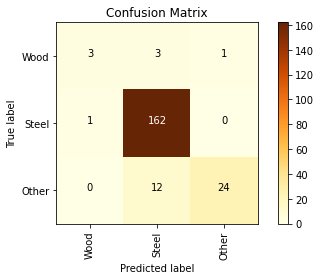

In [53]:
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

### XGBoost

In [54]:
# XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric='mlogloss'
    ))
])

# Fit the model
xgb_pipeline.fit(train_raw, target)

# Predict
predicted = xgb_pipeline.predict(test_raw)

# Accuracy
acc = accuracy_score(target_test, predicted)

# F1 score (use 'weighted' for multiclass)
f1 = f1_score(target_test, predicted, average='weighted')

print(f"Random Forest Accuracy: {acc:.3f}")
print(f"Random Forest F1 Score: {f1:.3f}")

# Detailed breakdown
print("\nClassification Report:\n", classification_report(target_test, predicted))

Random Forest Accuracy: 0.908
Random Forest F1 Score: 0.903

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.43      0.55         7
           1       0.93      0.97      0.95       163
           2       0.79      0.72      0.75        36

    accuracy                           0.91       206
   macro avg       0.82      0.71      0.75       206
weighted avg       0.90      0.91      0.90       206



/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


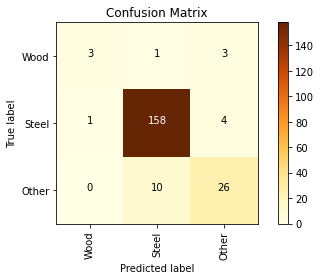

In [55]:
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

### Support Vector Machines

In [56]:
# Support Vector Machines
svm = SVC()
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
print("Number of support vectors:", svm.n_support_)

Accuracy:    0.902913
F1:          0.897130
Number of support vectors: [ 30 310 128]


In [57]:
svm = SVC(kernel = 'linear')
svm.fit(train, target)
predicted = svm.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
print("Number of support vectors:", svm.n_support_)

Accuracy:    0.932039
F1:          0.928710
Number of support vectors: [ 28 277 109]


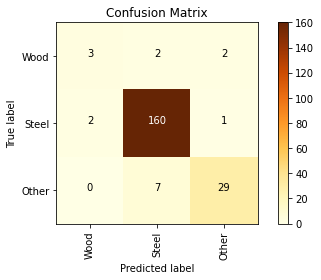

In [58]:
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

In [59]:
# Support Vector Machines Pipeline
svm_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Scale the features
    ('svm', SVC(random_state=42))  # Step 2: Apply Support Vector Classifier
])
svm_pipeline.fit(train, target)
predicted = svm_pipeline.predict(test)
svm_model = svm_pipeline.named_steps['svm']
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
print("Number of support vectors:", svm_model.n_support_)

Accuracy:    0.830097
F1:          0.779940
Number of support vectors: [ 30 590 141]


In [60]:
svm_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('svm', SVC(random_state=42, kernel = 'linear'))  # Apply Support Vector Classifier with linear kernel
])
svm_pipeline.fit(train, target)
predicted = svm_pipeline.predict(test)
svm_model = svm_pipeline.named_steps['svm']
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test, predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
print("Number of support vectors:", svm_model.n_support_)

Accuracy:    0.917476
F1:          0.910075
Number of support vectors: [ 29 583 139]


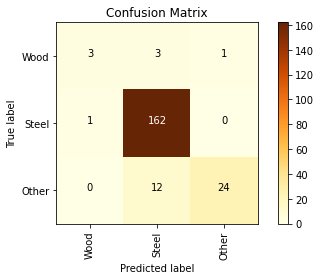

In [61]:
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

### Decision Tree

Accuracy:    0.907767
F1:          0.904380


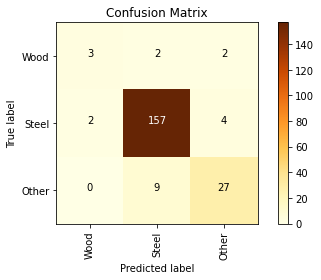

In [62]:
# Decision Tree
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

[Text(0.5, 0.8333333333333334, 'cat__Model_Unknown <= 0.5\ngini = 0.342\nsamples = 100.0%\nvalue = [0.036, 0.792, 0.172]'),
 Text(0.25, 0.5, 'cat__Manufacturer_Philadelphia Toboggan Coasters <= 0.5\ngini = 0.146\nsamples = 71.7%\nvalue = [0.02, 0.922, 0.058]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'num__Length_ft <= -0.056\ngini = 0.568\nsamples = 28.3%\nvalue = [0.077, 0.464, 0.459]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

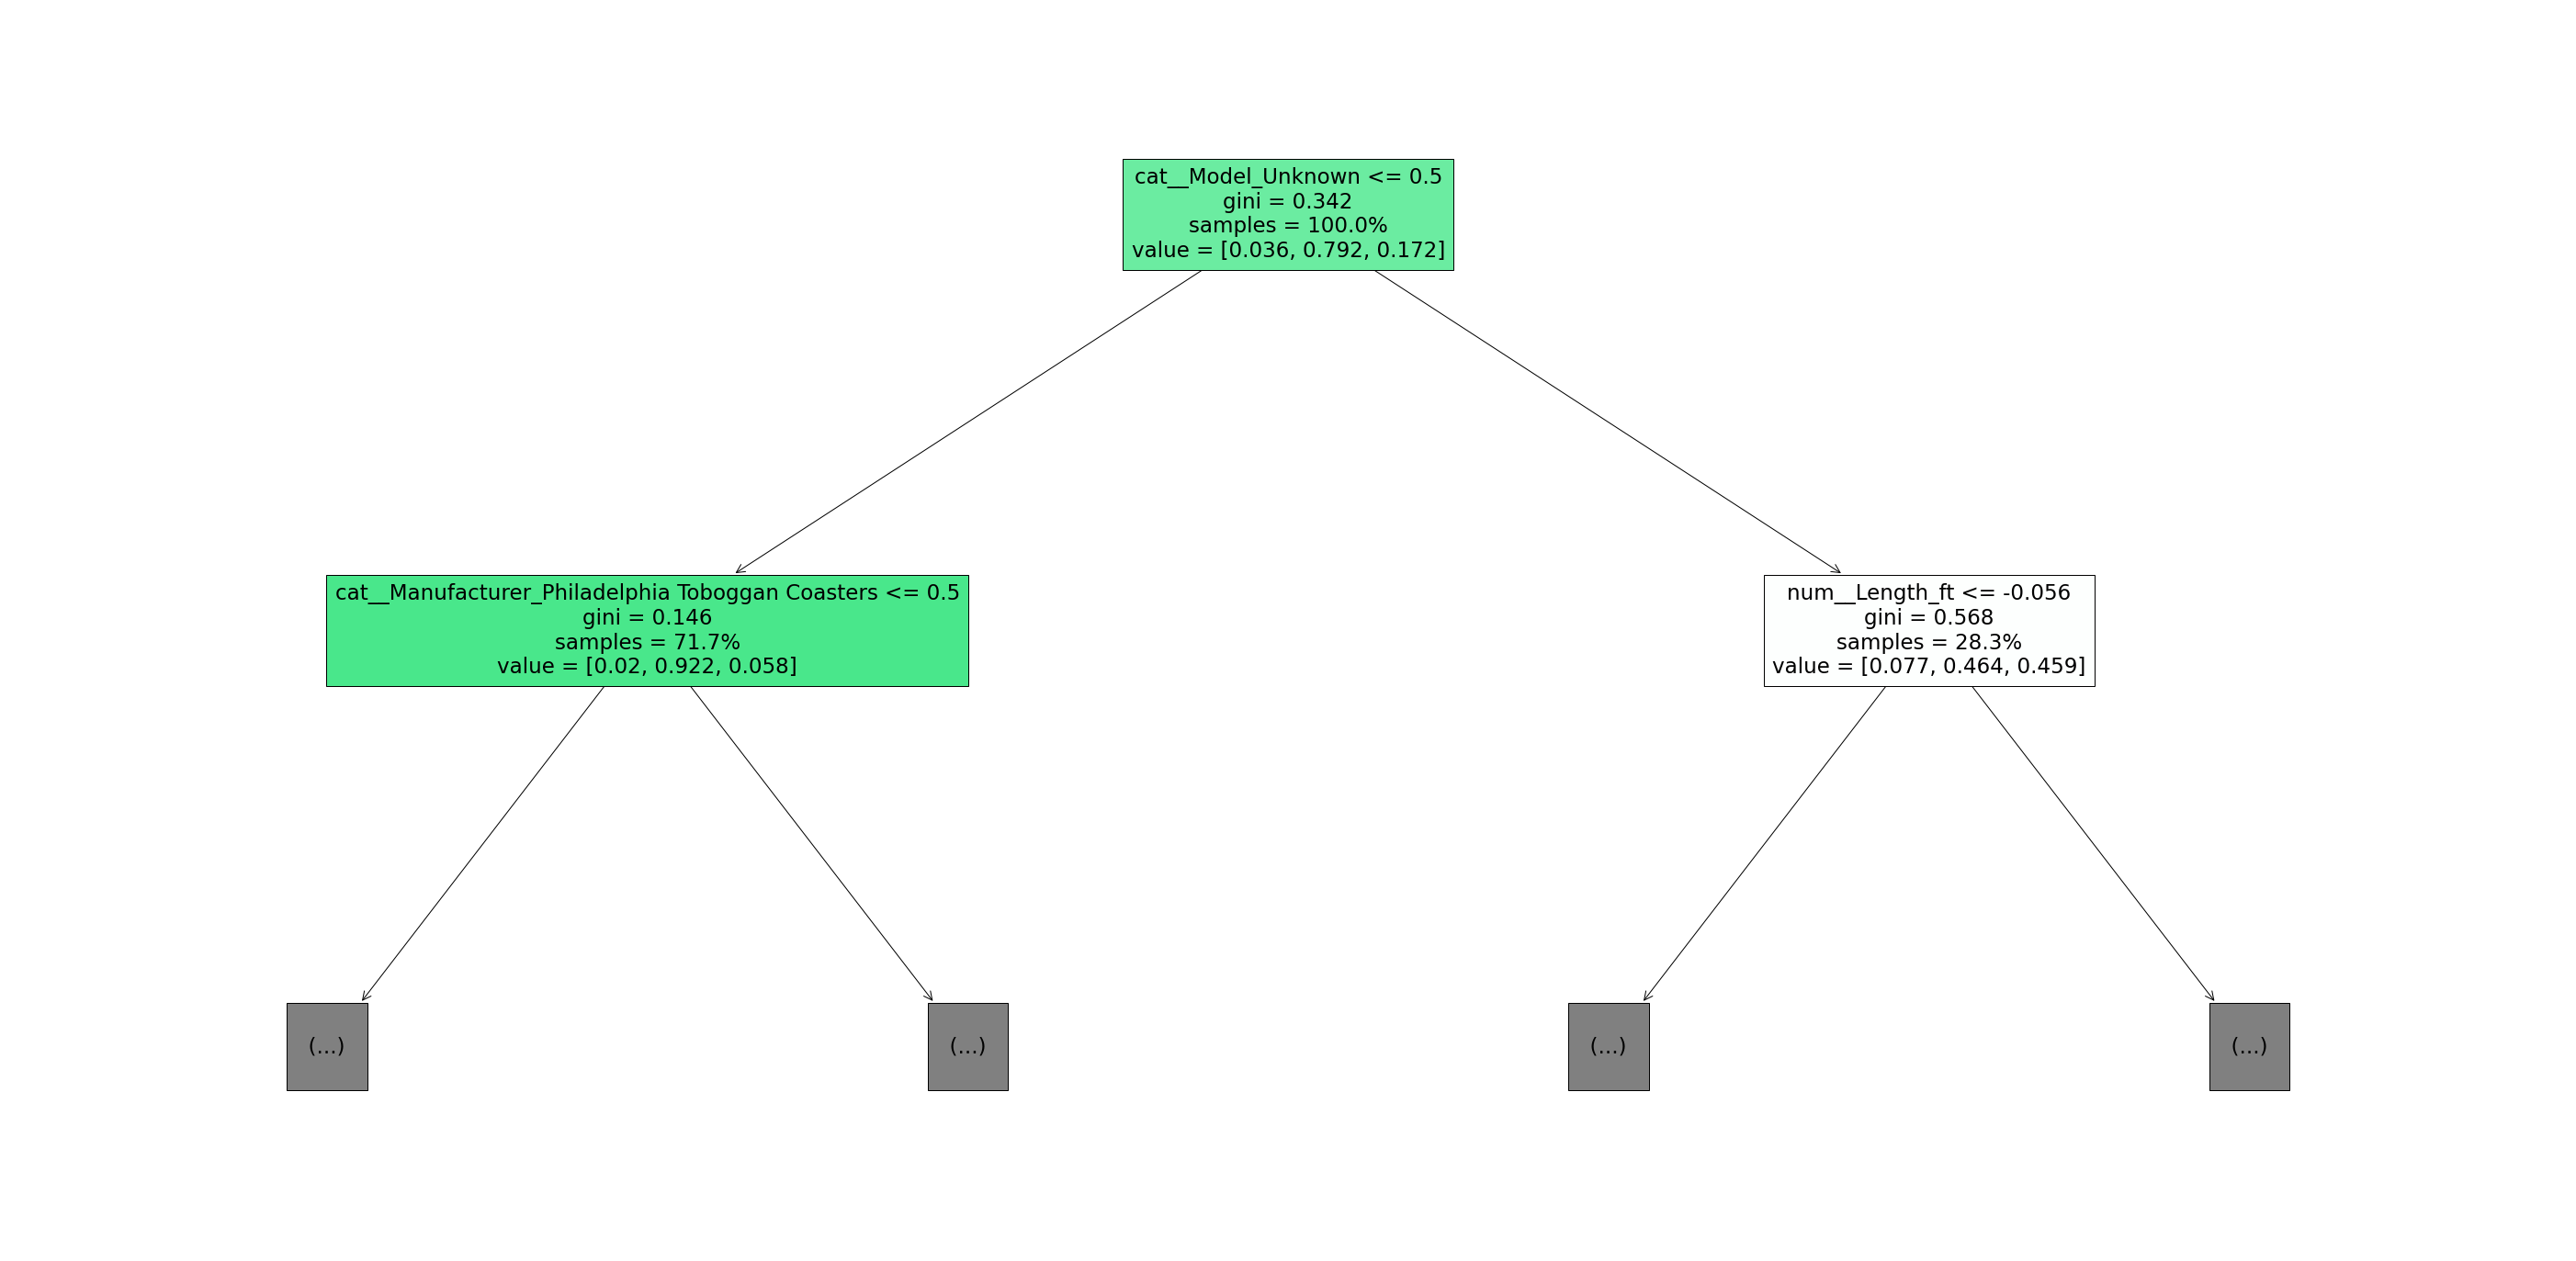

In [63]:
# Visualize some layers of the decision tree
plt.figure(figsize = (50,25)) 
sklearn.tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

In [64]:
# Use grid search to find the best parameters of decision tree and its accuracy
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3)

grid_search.fit(train, target)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
Best score: 0.9075425790754258


In [65]:
# Decision Tree pipeline
dt_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),  # scaling is optional for trees, but harmless
    ('dt', DecisionTreeClassifier(random_state=42))
])

# Fit model
dt_pipeline.fit(train, target)

# Predict on test data
predicted = dt_pipeline.predict(test)

# Evaluate performance
print(f"Decision Tree Accuracy: {metrics.accuracy_score(target_test, predicted):.3f}")
print(f"Decision Tree F1 (weighted): {metrics.f1_score(target_test, predicted, average='weighted'):.3f}")

# Optional: print feature importance
dt_model = dt_pipeline.named_steps['dt']
print("Feature Importances:", dt_model.feature_importances_)

Decision Tree Accuracy: 0.903
Decision Tree F1 (weighted): 0.900
Feature Importances: [0.         0.04701064 0.         ... 0.         0.         0.        ]


Accuracy:    0.902913
F1:          0.899551


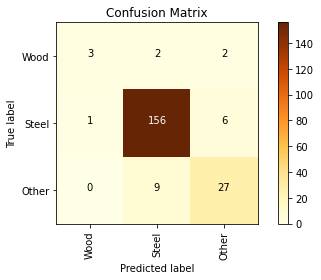

In [66]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("%-12s %f" % ('F1:', metrics.f1_score(target_test, predicted, average = 'weighted')))
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

[Text(0.4583333333333333, 0.875, 'x1317 <= 0.48\ngini = 0.342\nsamples = 100.0%\nvalue = [0.036, 0.792, 0.172]'),
 Text(0.25, 0.625, 'x1052 <= 2.735\ngini = 0.146\nsamples = 71.7%\nvalue = [0.02, 0.922, 0.058]'),
 Text(0.16666666666666666, 0.375, 'x1025 <= 3.007\ngini = 0.133\nsamples = 71.0%\nvalue = [0.021, 0.93, 0.05]'),
 Text(0.08333333333333333, 0.125, '\n  (...)  \n'),
 Text(0.25, 0.125, '\n  (...)  \n'),
 Text(0.3333333333333333, 0.375, 'gini = 0.0\nsamples = 0.6%\nvalue = [0.0, 0.0, 1.0]'),
 Text(0.6666666666666666, 0.625, 'Length_ft <= -0.056\ngini = 0.568\nsamples = 28.3%\nvalue = [0.077, 0.464, 0.459]'),
 Text(0.5, 0.375, 'x984 <= 4.994\ngini = 0.556\nsamples = 14.5%\nvalue = [0.143, 0.597, 0.261]'),
 Text(0.4166666666666667, 0.125, '\n  (...)  \n'),
 Text(0.5833333333333334, 0.125, '\n  (...)  \n'),
 Text(0.8333333333333334, 0.375, 'Capacity_riders_per_hour <= 0.655\ngini = 0.45\nsamples = 13.9%\nvalue = [0.009, 0.325, 0.667]'),
 Text(0.75, 0.125, '\n  (...)  \n'),
 Text(0.

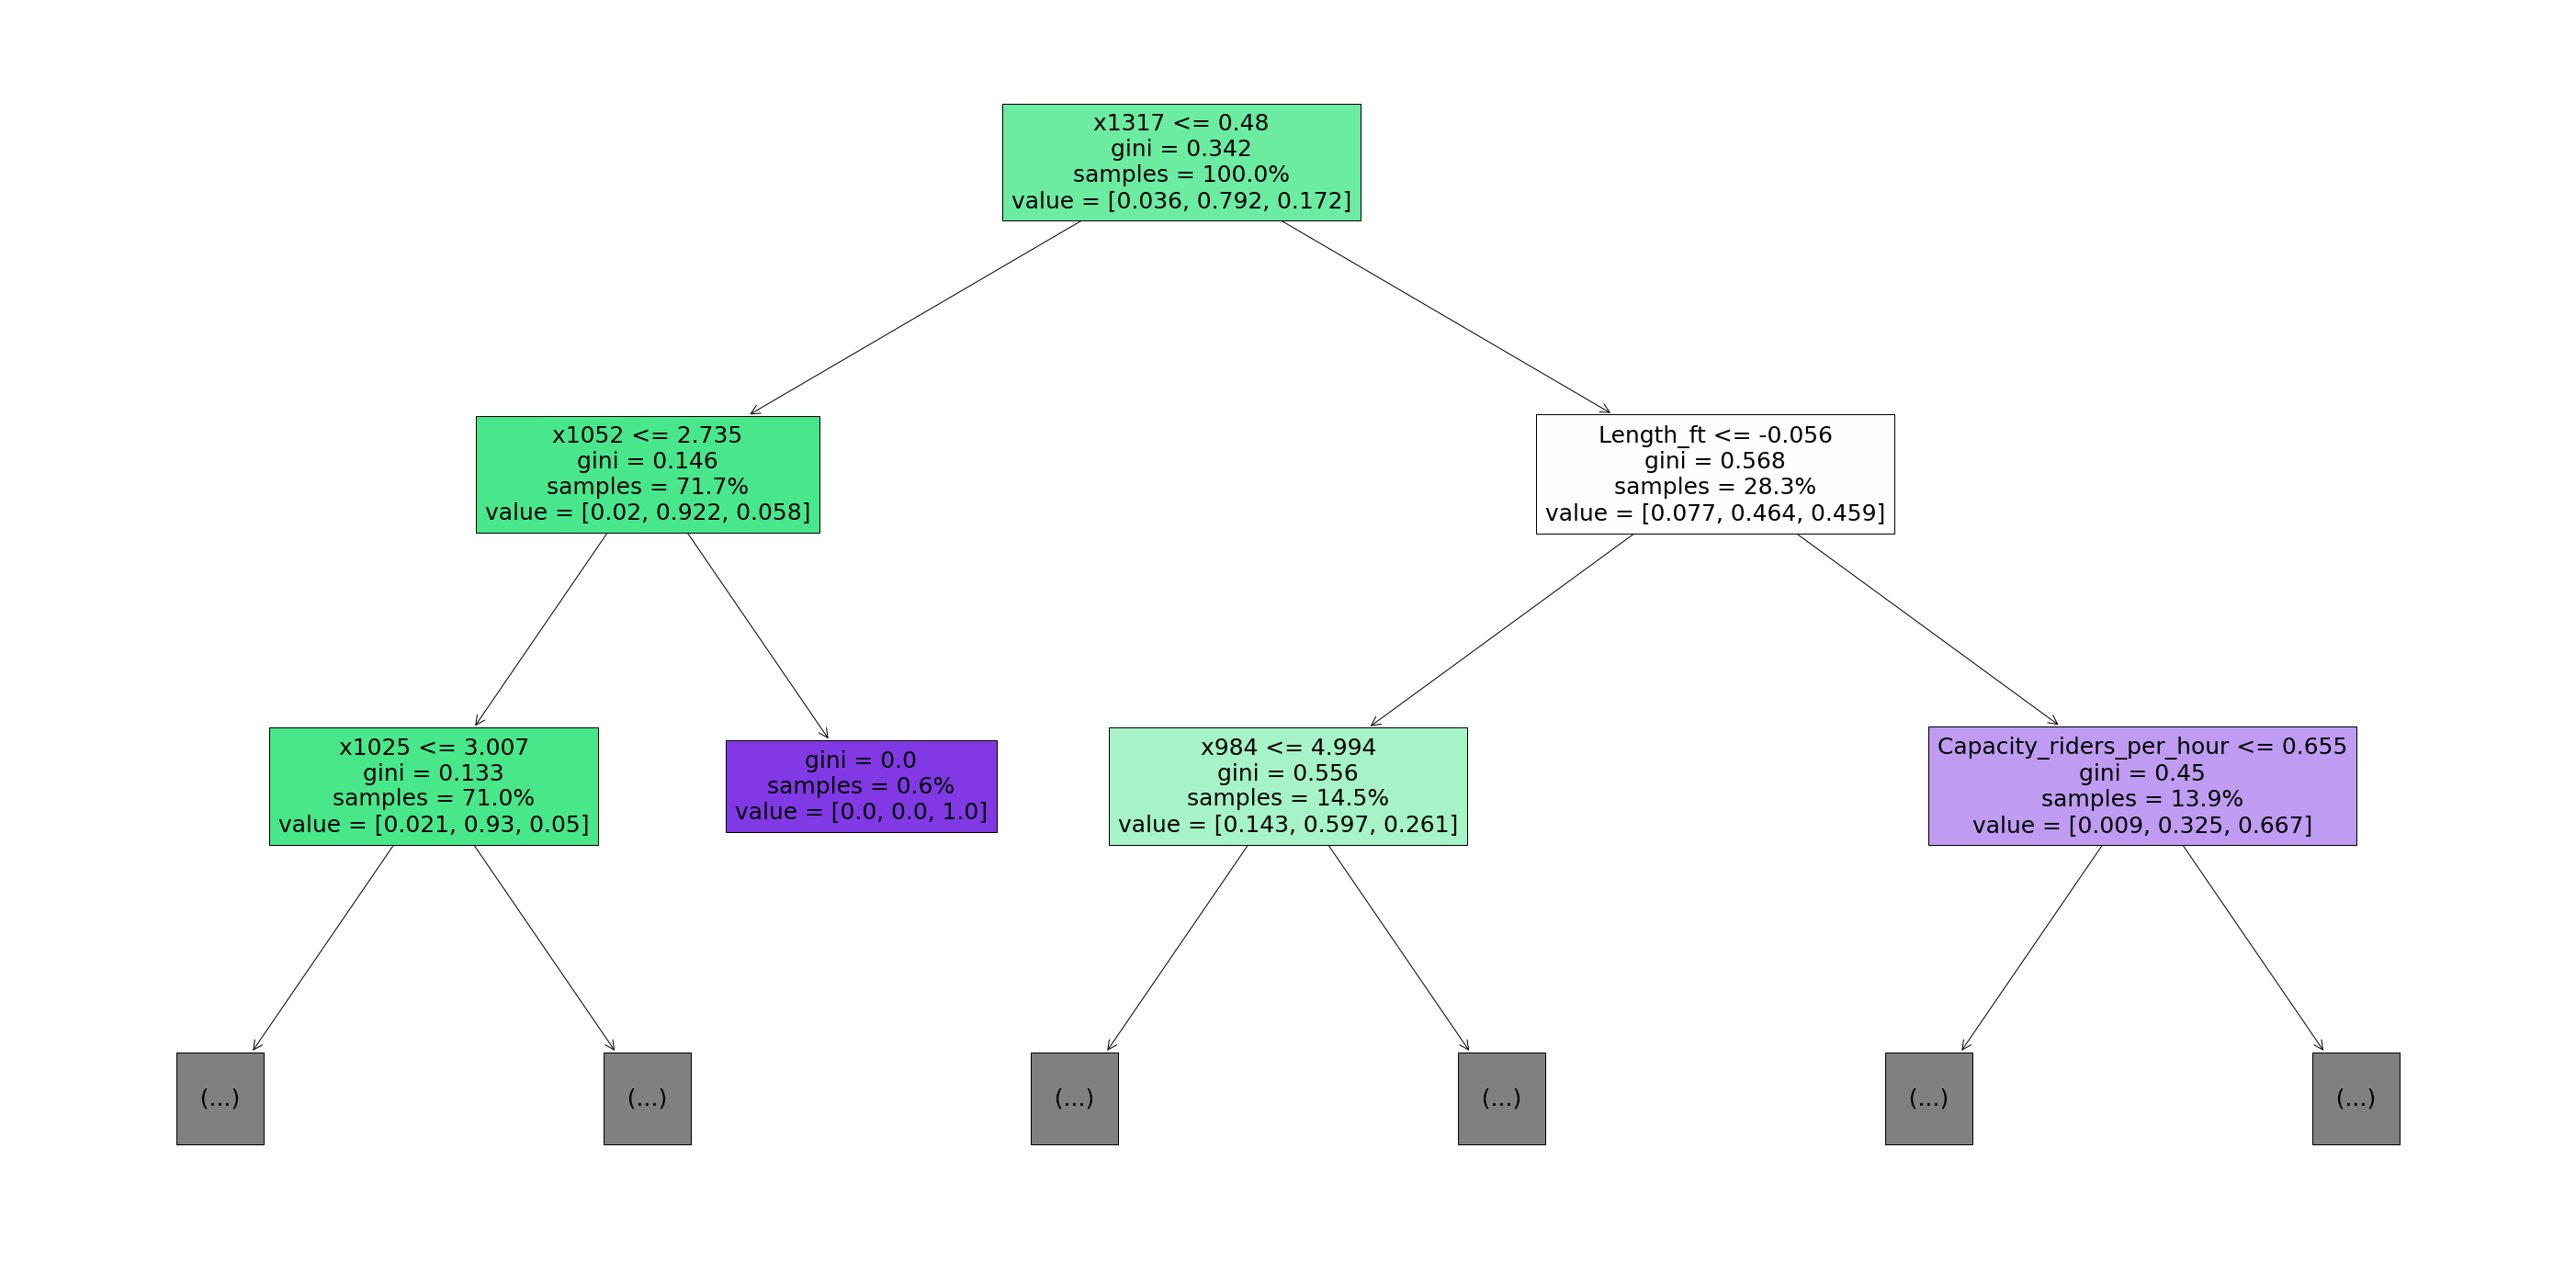

In [67]:
# Visualize some layers of the decision tree
dt_model = dt_pipeline.named_steps['dt']
feature_names = num + list(dt_pipeline.named_steps['scaler'].get_feature_names_out()) if 'scaler' in dt_pipeline.named_steps else num
min_len = min(len(feature_names), len(dt_model.feature_importances_))
feature_names = feature_names[:min_len]

plt.figure(figsize = (50,25)) 
sklearn.tree.plot_tree(dt_model,max_depth=2, proportion=True,feature_names=feature_names, filled=True)

In [68]:
# Use grid search to find the best parameters of decision tree and its accuracy
param_grid = {
    'max_depth': [1, 2, 3, 4, 5, 10, 15],
    'min_samples_split': [2, 4, 6, 8],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=3)

grid_search.fit(train, target)


print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2}
Best score: 0.9099756690997567


### Multi-Layer Perceptron

Train Accuracy: 0.9174757281553398
F1: [0.5        0.95412844 0.82191781]
F1 weighted average: 0.915592


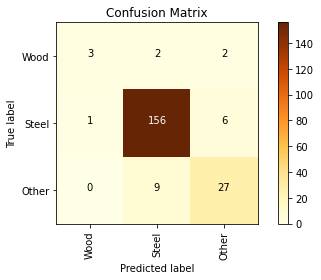

In [69]:
# Multi-Layer Perceptron
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=800, random_state=0)
mlp_classifier.fit(train, target)
y_train_pred = mlp_classifier.predict(test)
train_accuracy = accuracy_score(target_test, y_train_pred)
print("Train Accuracy:", train_accuracy)
print("F1:", f1_score(target_test, y_train_pred, average = None))
print("%-12s %f" % ('F1 weighted average:', metrics.f1_score(target_test, y_train_pred, average = 'weighted')))

draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])

/Users/dha/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:241: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 4, 5, 6, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Accuracy: 0.9223
Weighted F1: 0.9201


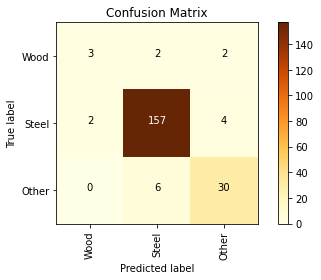

In [70]:
# MLP pipeline
mlp_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50),  # two hidden layers: 100 and 50 neurons
        activation='relu',             # ReLU activation
        solver='adam',                 # Adam optimizer
        max_iter=500,                  # give it plenty of iterations
        random_state=42
    ))
])

# Fit
mlp_pipeline.fit(train_raw, target)

# Predict
predicted = mlp_pipeline.predict(test_raw)

# Evaluate
acc = accuracy_score(target_test, predicted)
f1 = f1_score(target_test, predicted, average='weighted')

print(f"Accuracy: {acc:.4f}")
print(f"Weighted F1: {f1:.4f}")
draw_confusion_matrix(target_test, predicted, classes = ['Wood', 'Steel', 'Other'])